## Pair Fundamental Analsyis: Stationarity, Integration, Cointegration
**Based off of Andre Sealy's article on [Pairs Trading] (https://kidquant.com/project/pairs-trading-strategies-in-python/)**

Implementation of the Augmented Dickey Fuller Test for unit root null hypothesis testing, Engle-Granger for cointegration testing, and modeled application to equity pair search/exchange.

In [84]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import datetime
import yfinance as yf
import seaborn as sns 
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint, adfuller
from pandas_datareader import data as pdr

yf.pdr_override()
%config InlineBackend.figure_format = 'retina'
pd.core.common.is_list_like = pd.api.types.is_list_like
plt.rc('figure', figsize=(8, 5))
sns.set(style="whitegrid")

### Generate two random series as data, one of them with a multiplier to demonstrate non-stationarity through an increase per time

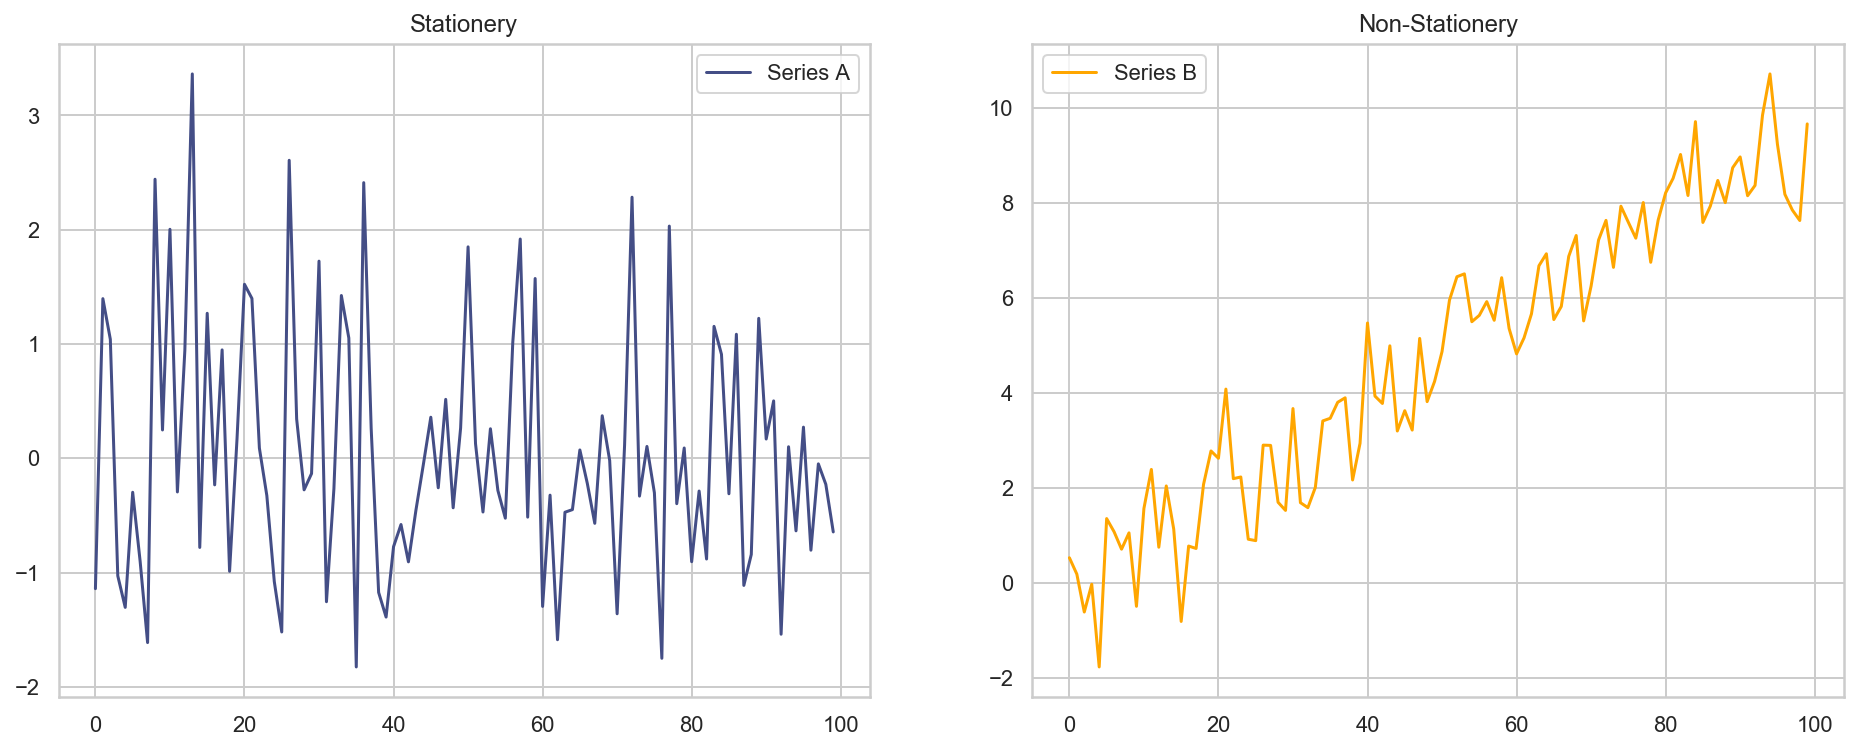

In [87]:
def gen_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)
    
params = (0,1)
T = 100

A = pd.Series(index = range(T), dtype = 'float64')
A.name = 'A'

for t in range(T):
    A[t] = gen_data(params)

T = 100
B = pd.Series(index = range(T), dtype = 'float64')
B.name = 'B'

for t in range(T):
    params = (t*0.1, 1)
    B[t] = gen_data(params)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
ax1.plot(A, color = '#444e86')
ax2.plot(B, color = '#ffa600')
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationery')
ax2.set_title('Non-Stationery')

plt.show()

### Augmented Dickey Fuller Test for Staionarity in Time Series
Testing for null hypothesis: 

H<sub>0</sub>: &Phi; = 1 -> y ~ I(0) | (unit root)

H<sub>1</sub>: |&Phi;| < 1 -> y ~ I(0) | (stationary)

In [88]:
def stationarity_test(X, cutoff = 0.01):
    #ADTest, H_0 is unit root exists (i.e. non-stationary)
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value: ' + str(pvalue) + ' The series ' + X.name + ' is likely stationary')
    else:
        print('p-value: ' + str(pvalue))

stationarity_test(A)
stationarity_test(B)

p-value: 5.8025510906409e-20 The series A is likely stationary
p-value: 0.8946845907590444


### Generate and display data for two cointegrated series with a noise shifter 

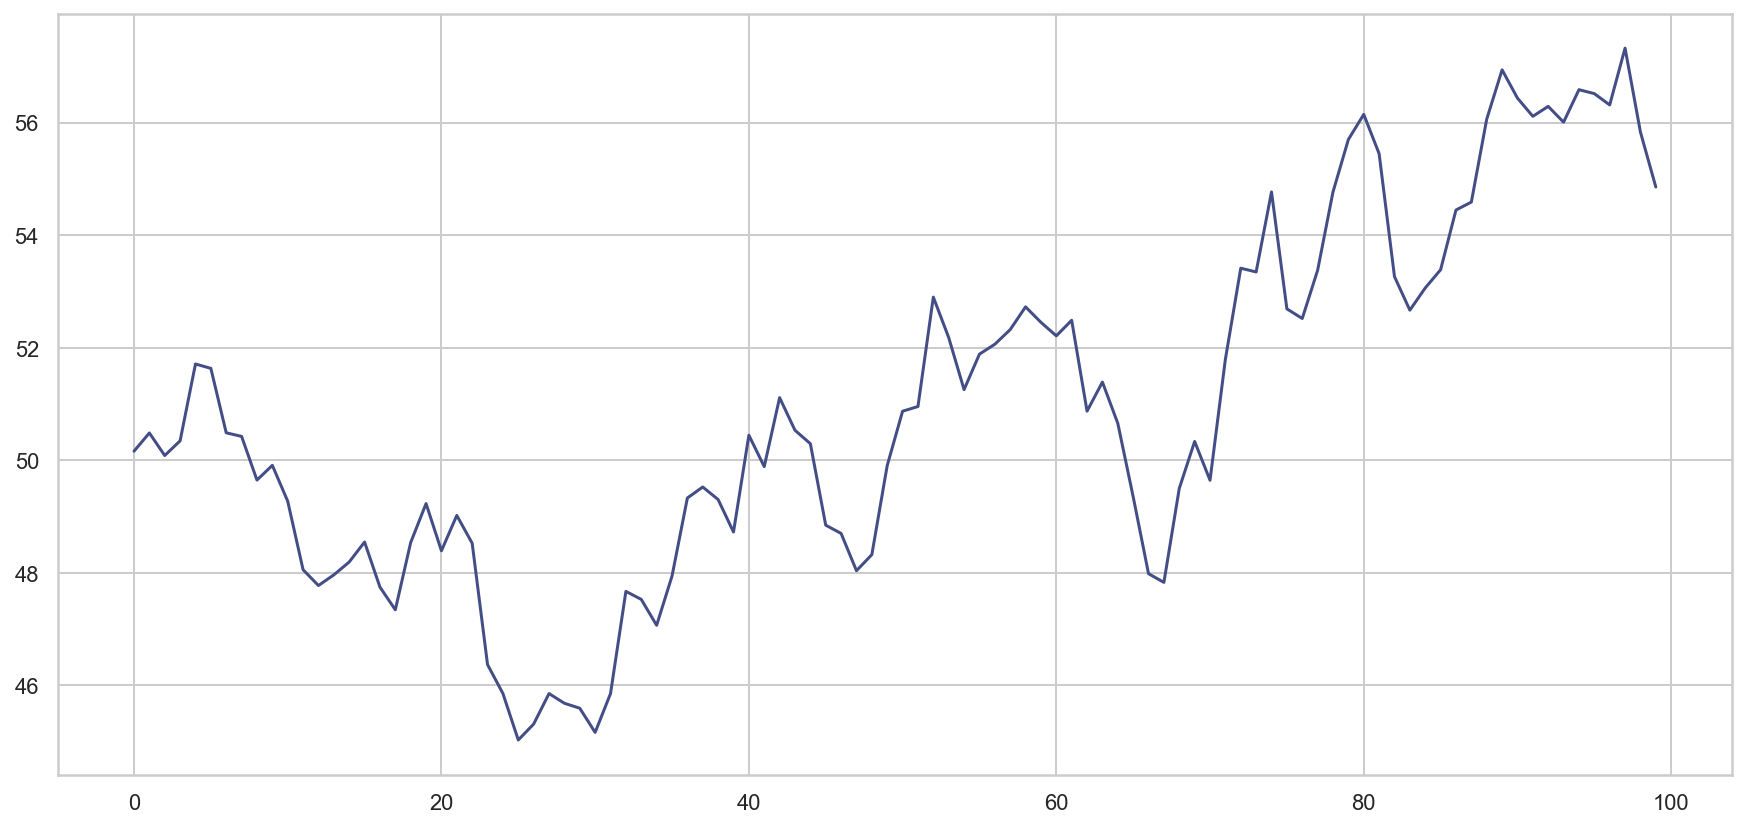

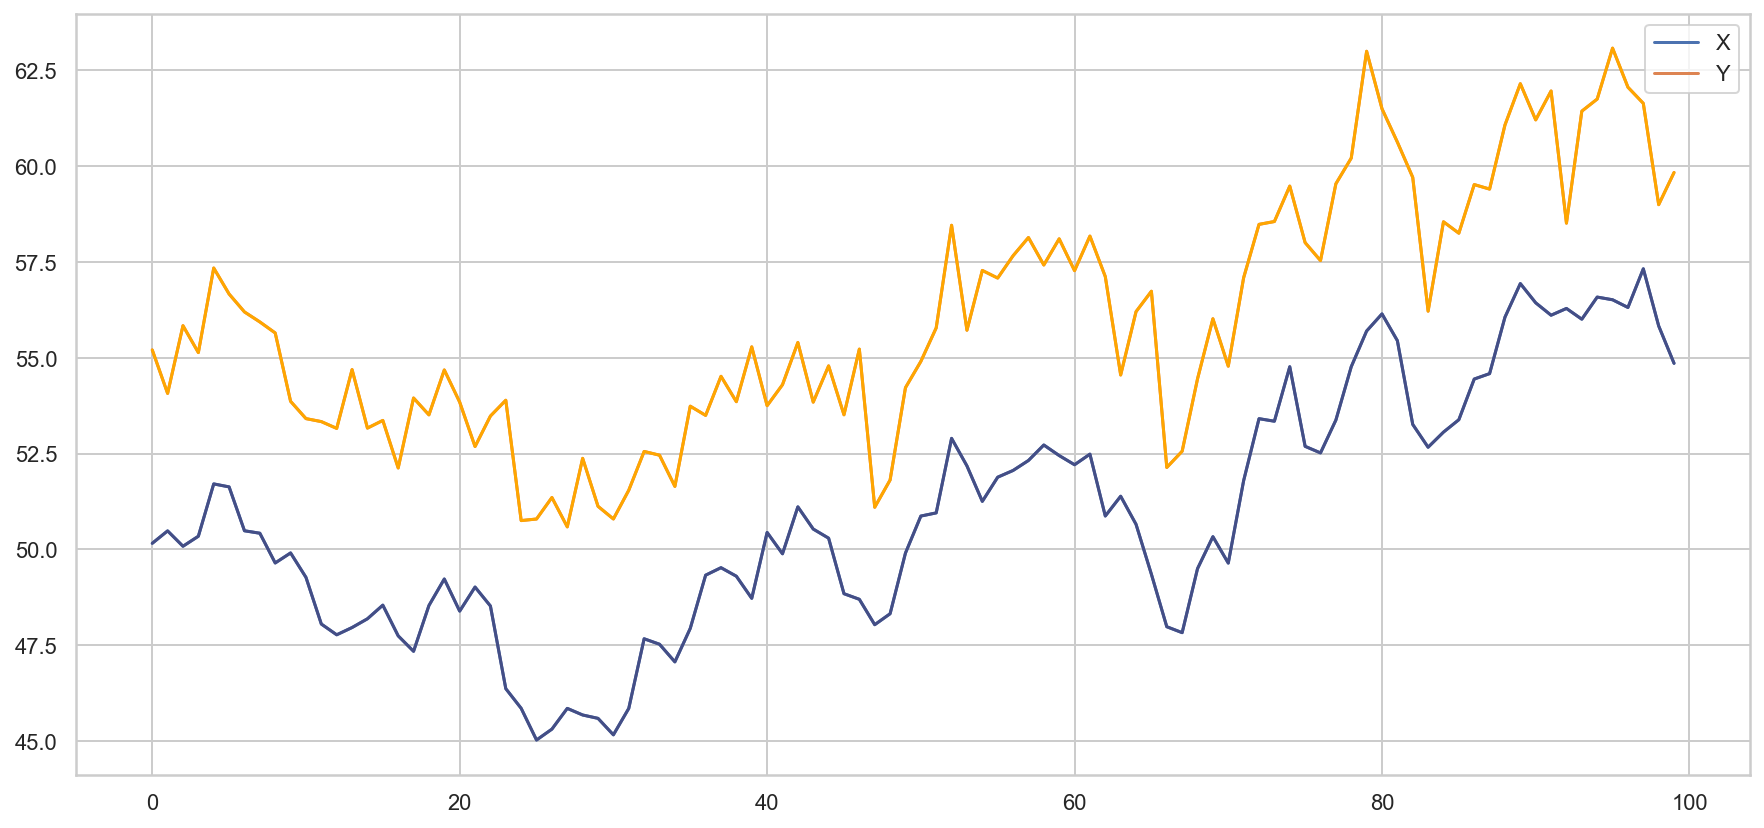

In [89]:
xret = np.random.normal(0, 1, 100)
X = pd.Series(np.cumsum(xret), name = 'X') + 50
X.plot(figsize = (15,7), color = '#444e86')

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis = 1).plot(figsize=(15,7))
X.plot(figsize = (15,7), color = '#444e86')
Y.plot(figsize = (15,7), color = '#ffa600')
plt.show()

### Plot the spread in the generated time series from above

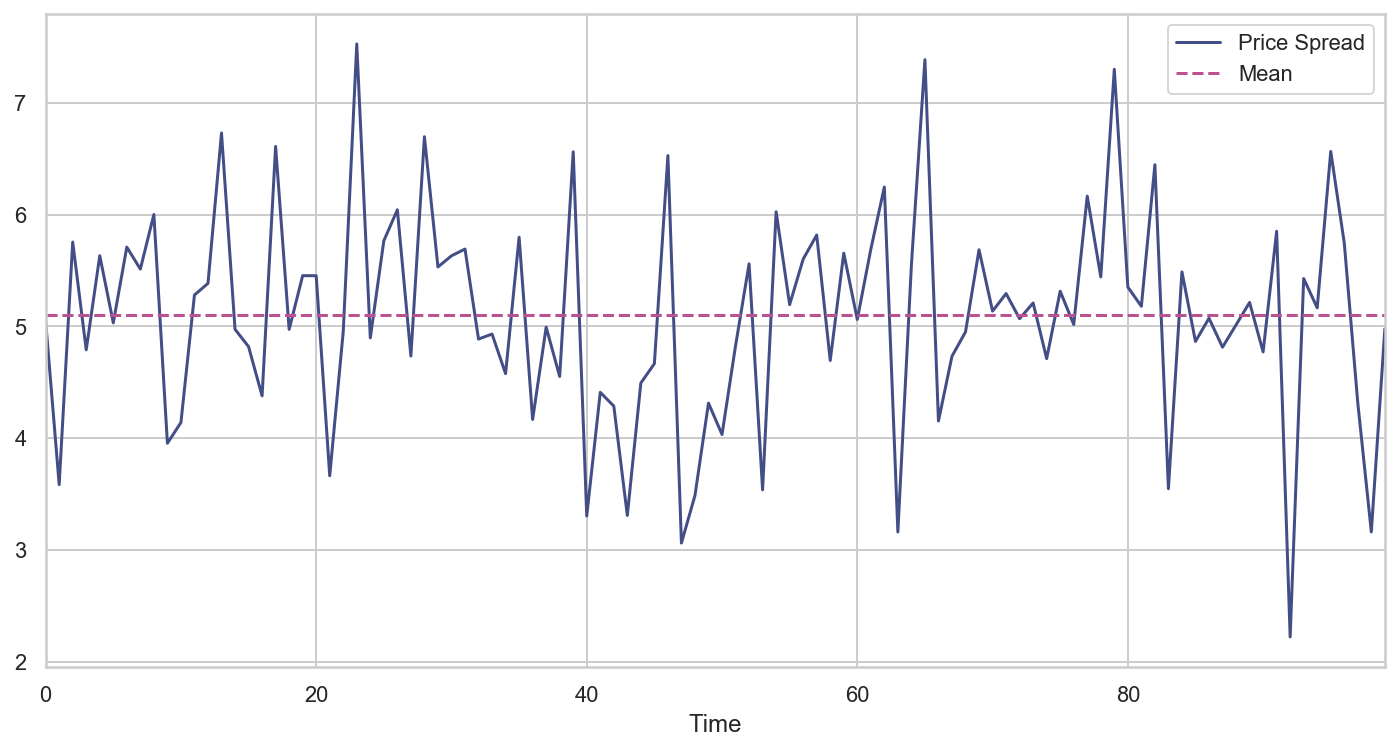

In [90]:
plt.figure(figsize=(12,6))
spread = Y - X
spread.plot(color = '#444e86') # Plot the spread
plt.axhline(spread.mean(), color='#bc5090', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

In [6]:
#Low p-value is indicative of high cointegration
score, pval, _ = coint(X, Y)
print(pval)

6.136727578350165e-14


### Demonstrate that correlation and cointegration are similar but not the same: time series can be highly correlated and not cointegrated and vice versa.

Correlation: -0.005376546753246556
Cointegration test p-value: 0.0


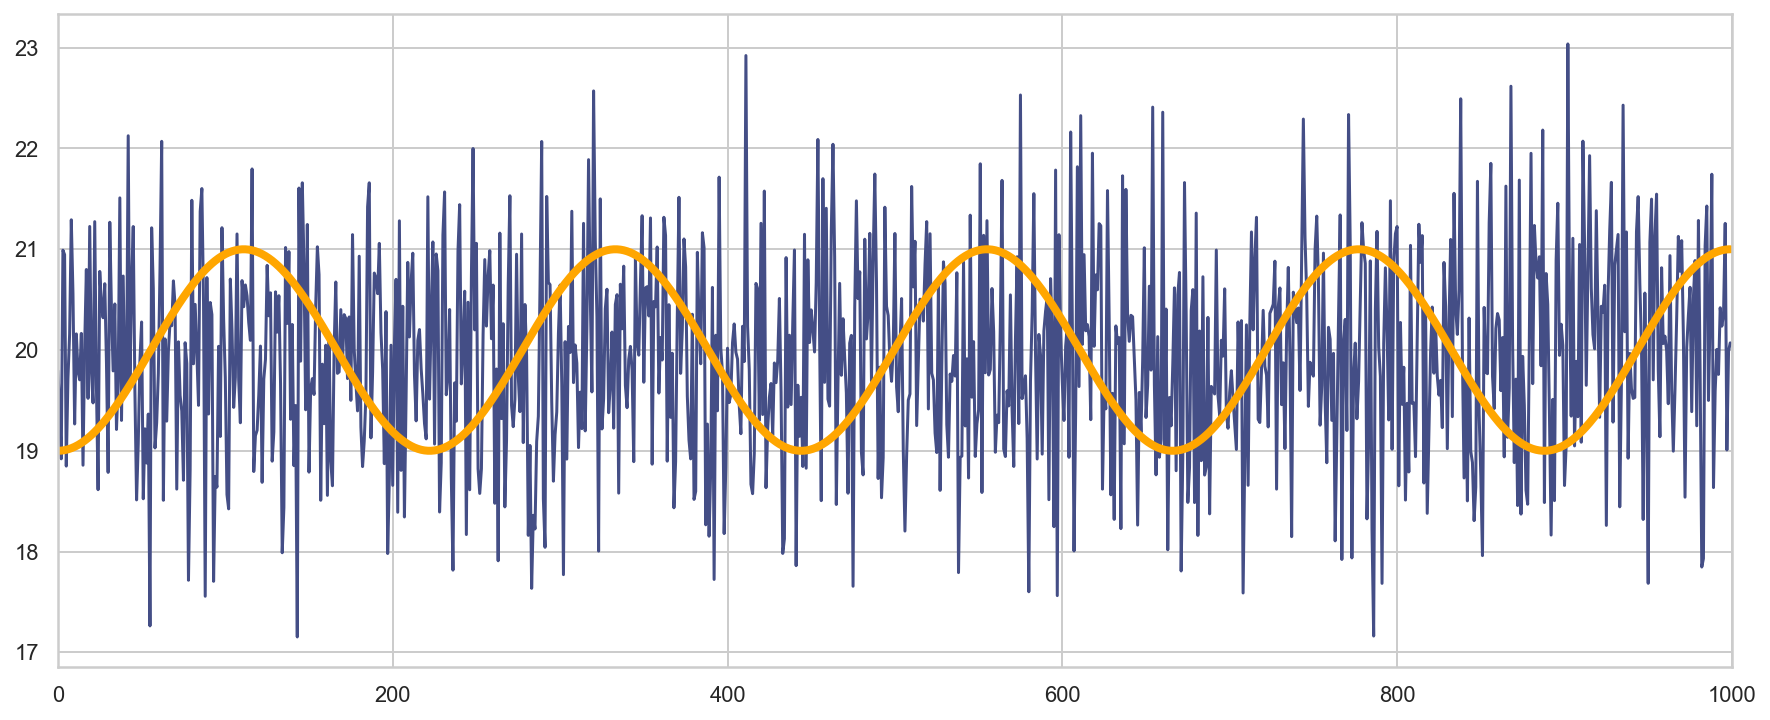

In [91]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
x = np.linspace(-np.pi, np.pi, 1000)
Y3 = pd.Series(np.sin(4.5*x) + 20, name = 'Y3')

plt.figure(figsize=(15,6))
Y2.plot(color = '#444e86')
Y3.plot(color='#ffa600', linewidth = 4)
plt.xlim([0, 1000])
# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

### Applying cointegration filter to historical equity data and generating signals


In [41]:
#Function that returns cointegration testing for data from equity tickers
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


Selection based on the preassumption that there are economic links between subsets of securities within the the tickers defined. In application, be wary of multiple comparison bias and p-hacking.

In [222]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['AAPL', 'MSFT', 'EBAY', 'TSLA', 'QCOM', 'AMD', 'NVDA', 'FB', 'INTC', 'AMZN', 'YELP', 'MU', 'PANDY', 'T', 'SPLK', 'SFUN', 'ADBE']

df = pdr.get_data_yahoo(tickers, start, end)['Close']
print(df.isnull().values.any()) #Check for NaNs--different IPO dates
df.tail()

[*********************100%***********************]  17 of 17 completed
False


,AAPL,ADBE,AMD,AMZN,EBAY,FB,INTC,MSFT,MU,NVDA,PANDY,QCOM,SFUN,SPLK,T,TSLA,YELP
Date,,,,,,,,,,,,,,,,,
2017-12-22,175.009995,175.000000,10.54,1168.359985,37.759998,177.199997,46.700001,85.510002,44.119999,195.270004,26.459999,64.730003,231.5,82.750000,38.939999,325.200012,41.910000
2017-12-26,170.570007,174.440002,10.46,1176.760010,37.939999,175.990005,46.080002,85.400002,42.250000,197.440002,26.480000,64.300003,237.0,82.269997,39.060001,317.290009,42.119999
2017-12-27,170.600006,175.360001,10.53,1182.260010,37.610001,177.619995,46.110001,85.709999,42.480000,197.169998,26.870001,64.540001,244.5,82.589996,38.889999,311.640015,42.299999
2017-12-28,171.080002,175.550003,10.55,1186.099976,37.919998,177.919998,46.220001,85.720001,41.810001,197.399994,26.980000,64.379997,244.5,82.290001,39.180000,315.359985,42.230000
2017-12-29,169.229996,175.240005,10.28,1169.469971,37.740002,176.460007,46.160000,85.540001,41.119999,193.500000,27.240000,64.019997,279.0,82.839996,38.880001,311.350006,41.959999


### Heatmap to show the p-values of the cointegration test between each pair of stocks. 

[('ADBE', 'EBAY'), ('ADBE', 'MSFT'), ('AMZN', 'EBAY'), ('EBAY', 'NVDA'), ('QCOM', 'YELP')]


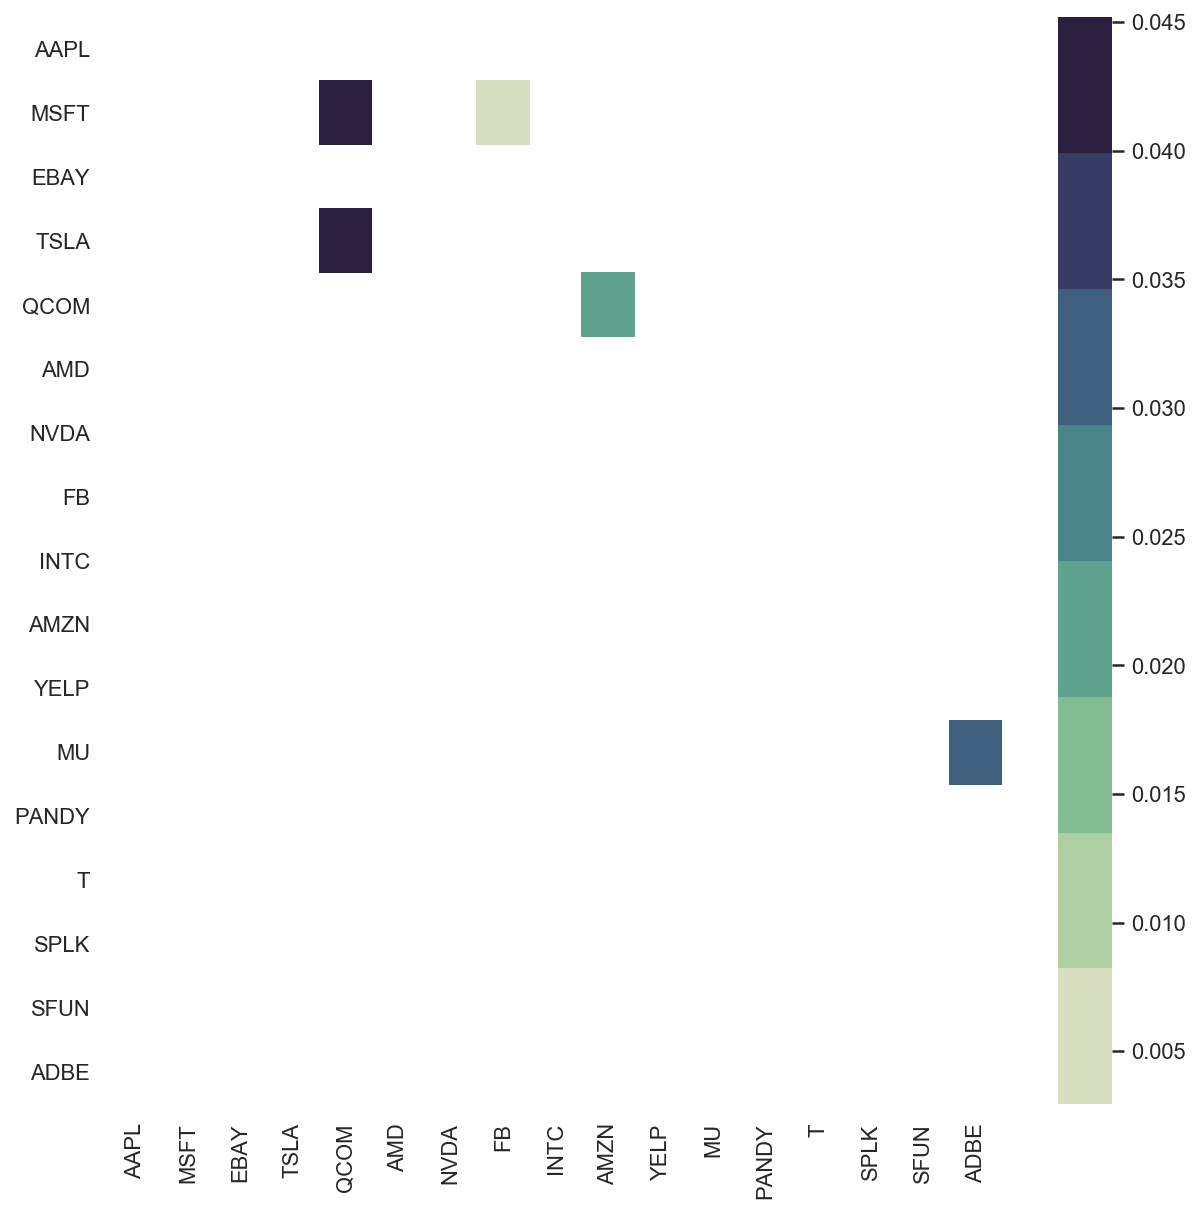

In [223]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75)
                , mask = (pvalues >= 0.05))
print(pairs)

### The cointegration function highlights multiple cointegrated equity pairs from the tickers listed.

In [208]:
# Double check cointegration function
S1 = df['AMZN']
S2 = df['EBAY']

score, pvalue, _ = coint(S1, S2)
pvalue

0.04035002225046762

### The spread analysis

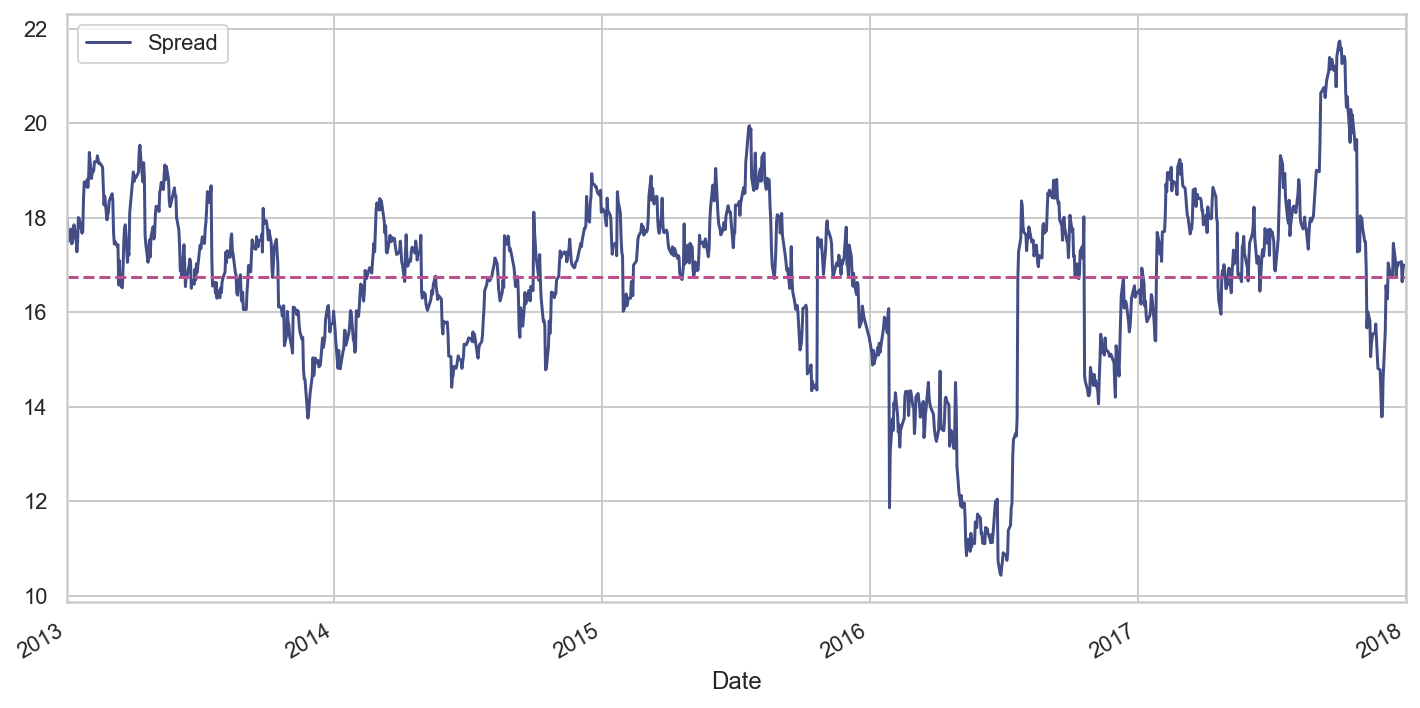

In [210]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AMZN']
b = results.params['AMZN']

spread = S2 - b * S1
spread.plot(figsize=(12,6), color = '#444e86')
plt.axhline(spread.mean(), color='#bc5090', linestyle='--')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

### The price ratio analysis (i.e. AMZN Close/EBAY Close)

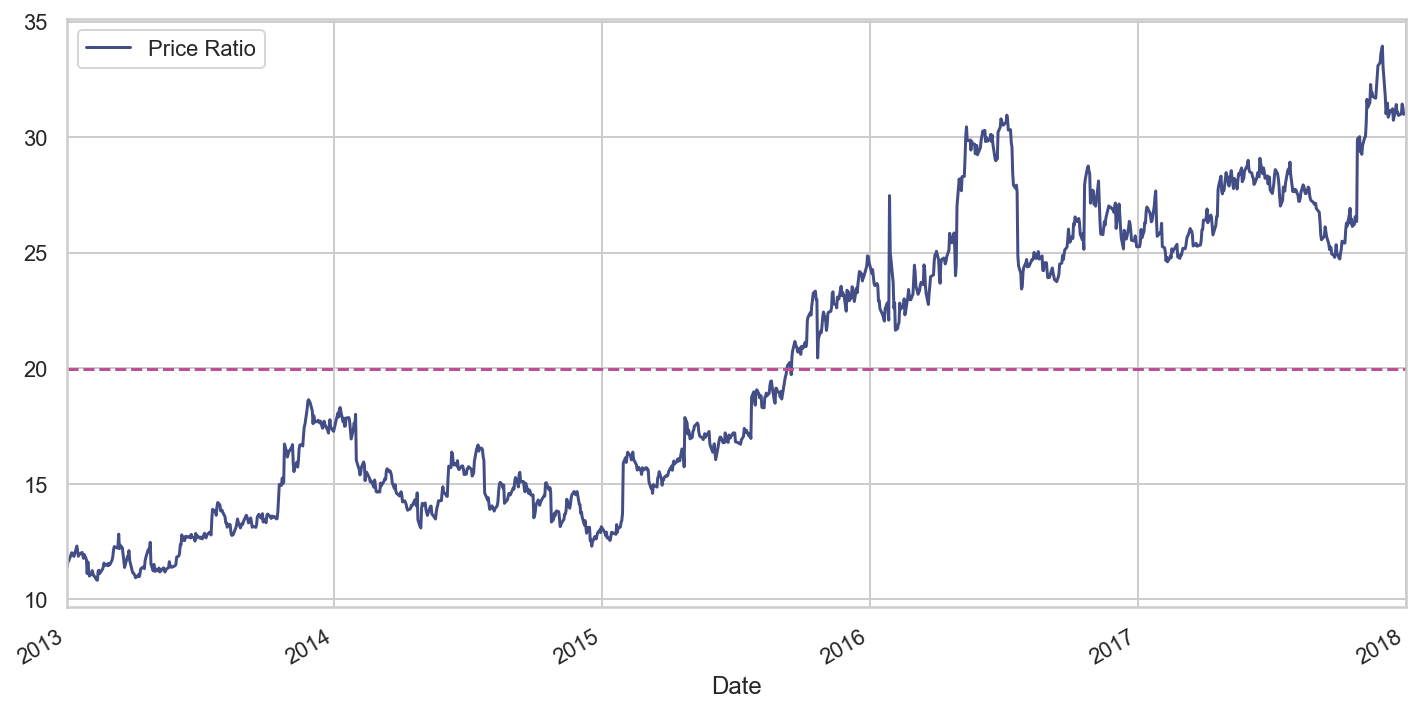

In [211]:
ratio = S1/S2
ratio.plot(figsize=(12,6), color = '#444e86')
plt.axhline(ratio.mean(), color='#bc5090', linestyle='--')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

### Standardizing and using the z-score is more useful and telling statistically; mean-reversion usually occurs between the first standard deviation

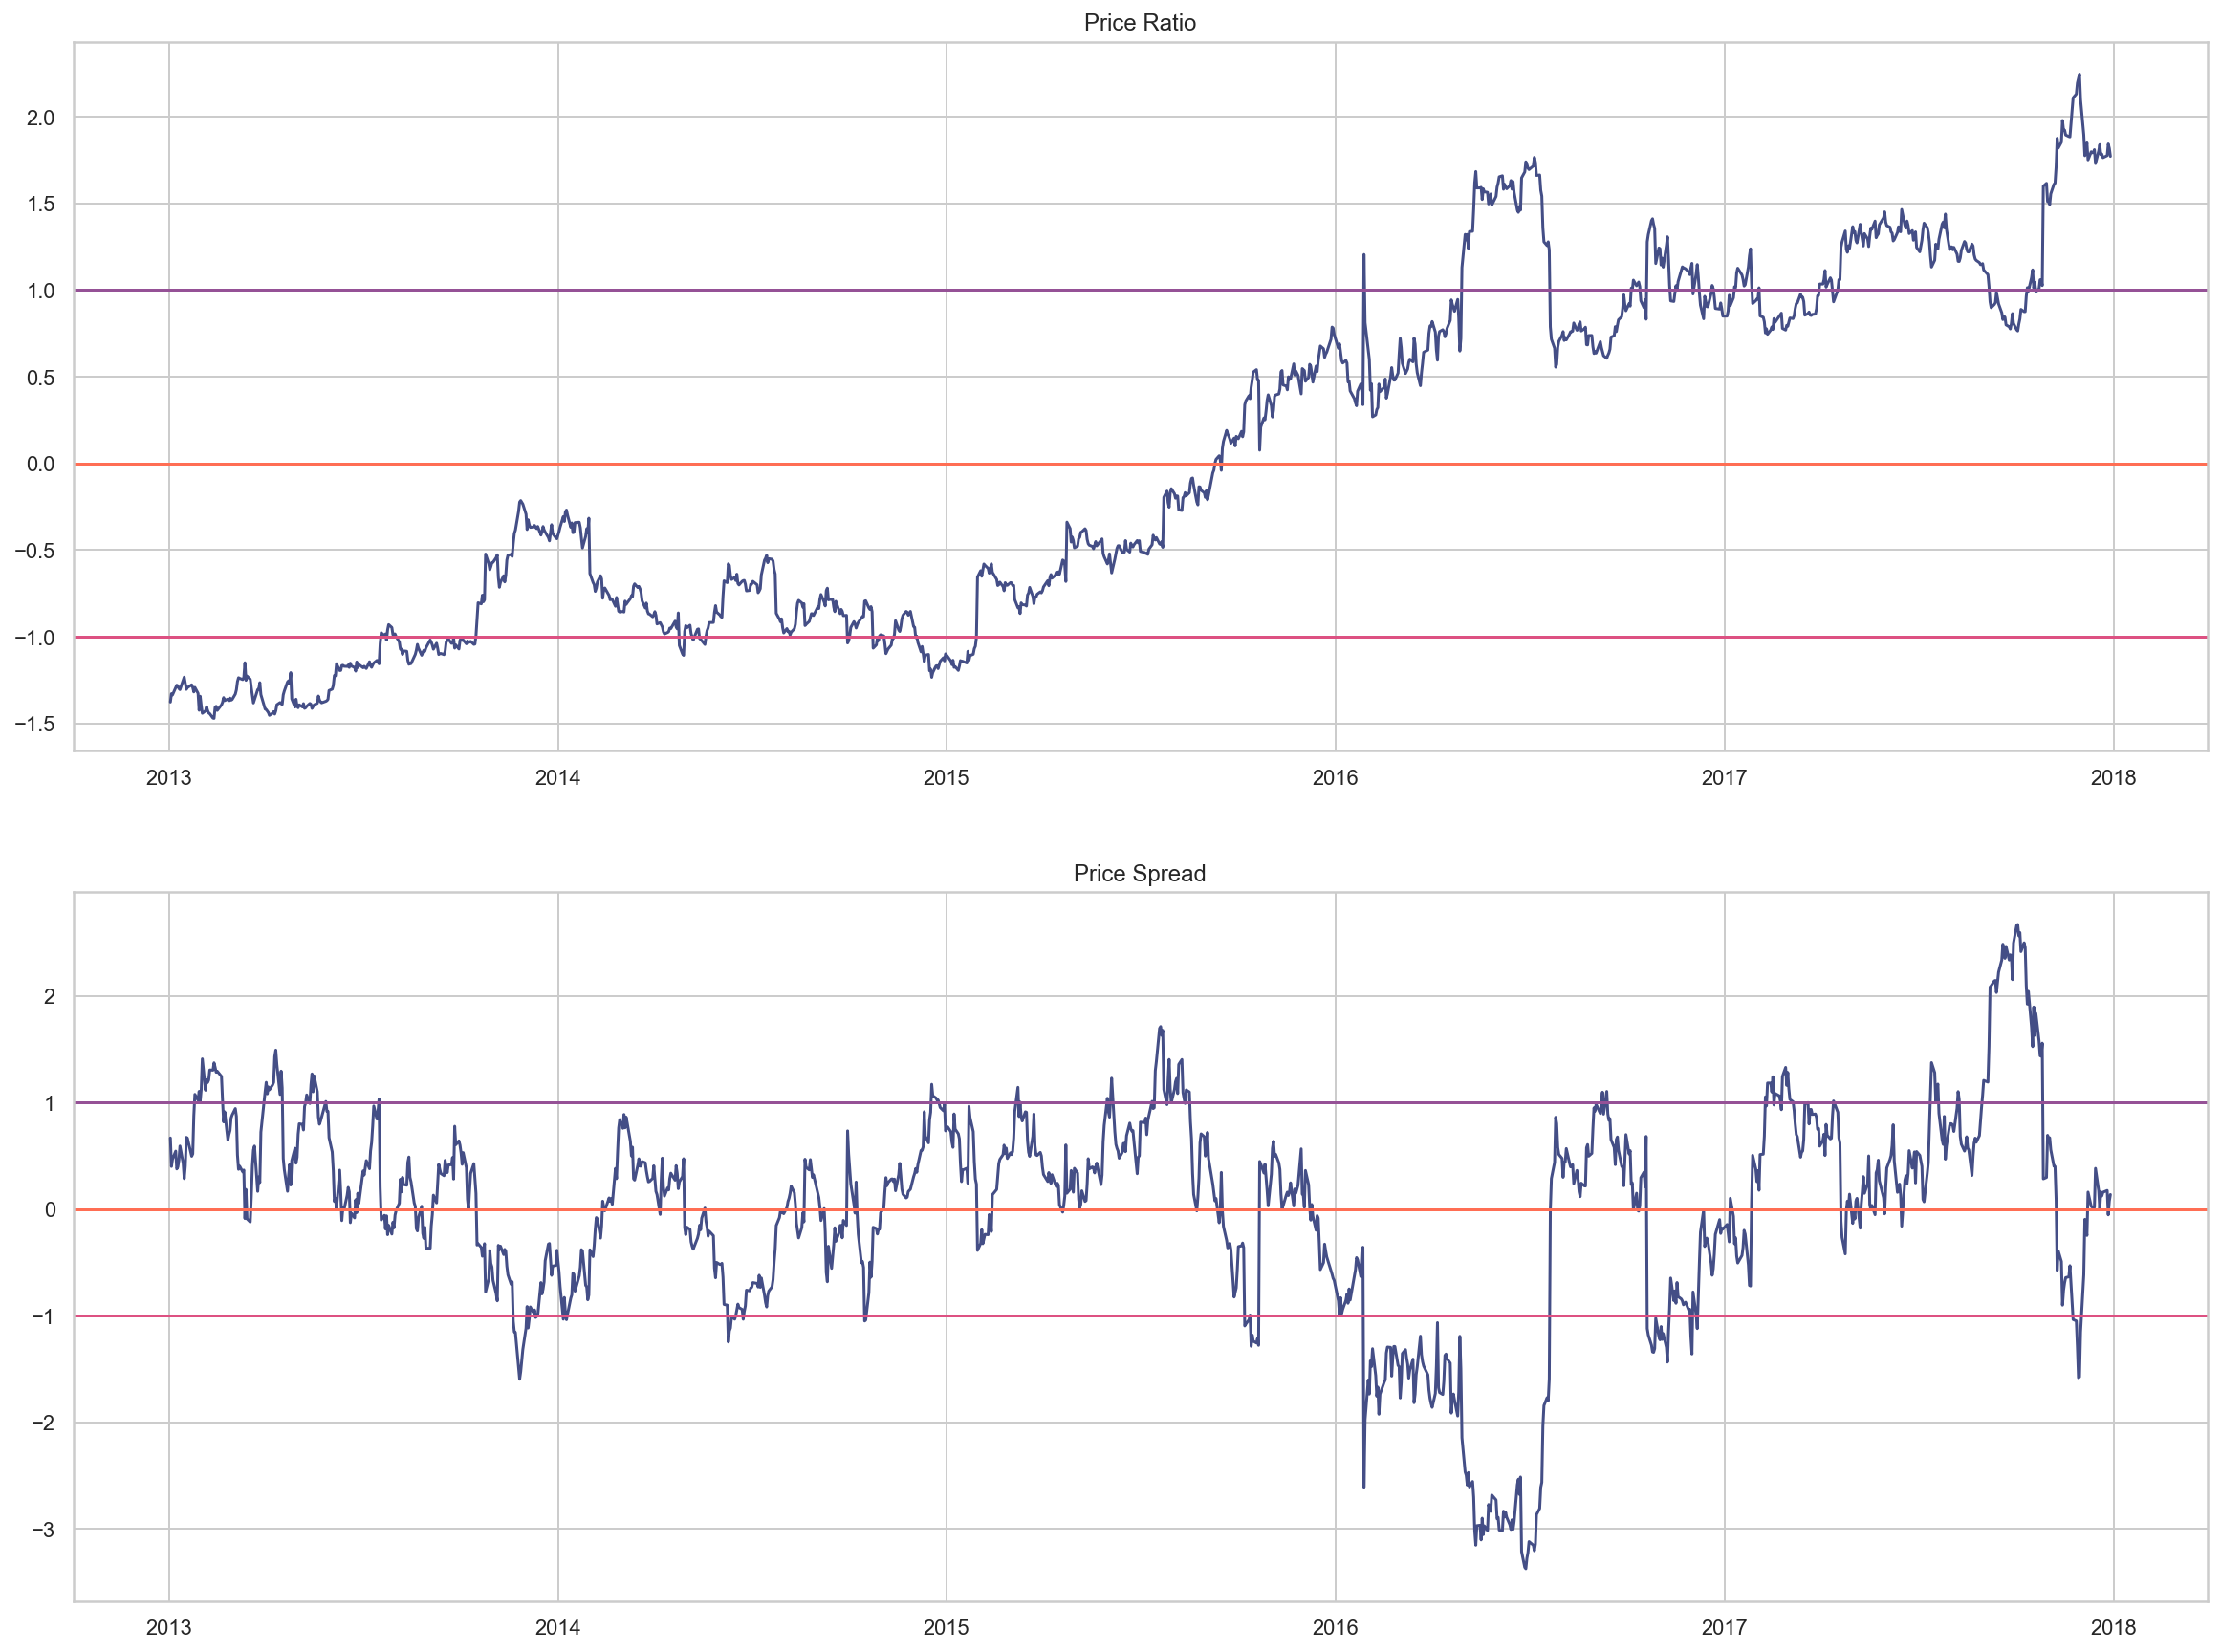

In [141]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20,15))
ax1.plot(zscore(ratio), color = '#444e86')
ax1.axhline(zscore(ratio).mean(), color = '#ff6e54')
ax1.axhline(1.0, color='#955196')
ax1.axhline(-1.0, color='#dd5182')
ax1.set_title('Price Ratio')

ax2.plot(zscore(spread), color = '#444e86')
ax2.axhline(zscore(ratio).mean(), color = '#ff6e54')
ax2.axhline(1.0, color='#955196')
ax2.axhline(-1.0, color='#dd5182')
ax2.set_title('Price Spread')


plt.show()

### Trading Signal Generation from Cointegrated Pairs

Theoretical implementation on historical data with pair data; trading signal is derived as &pm;(Ratio<sub>t+1</sub> - Ratio_<sub>t</sub>)


In [151]:
ratios = df['AMZN'] / df['EBAY'] 
print(len(ratios) * .70 )

881.3


In [153]:
train = ratios[:881]
test = ratios[881:]

### Generate and plot moving average between ratios in 5 day and 30 day rolling windows

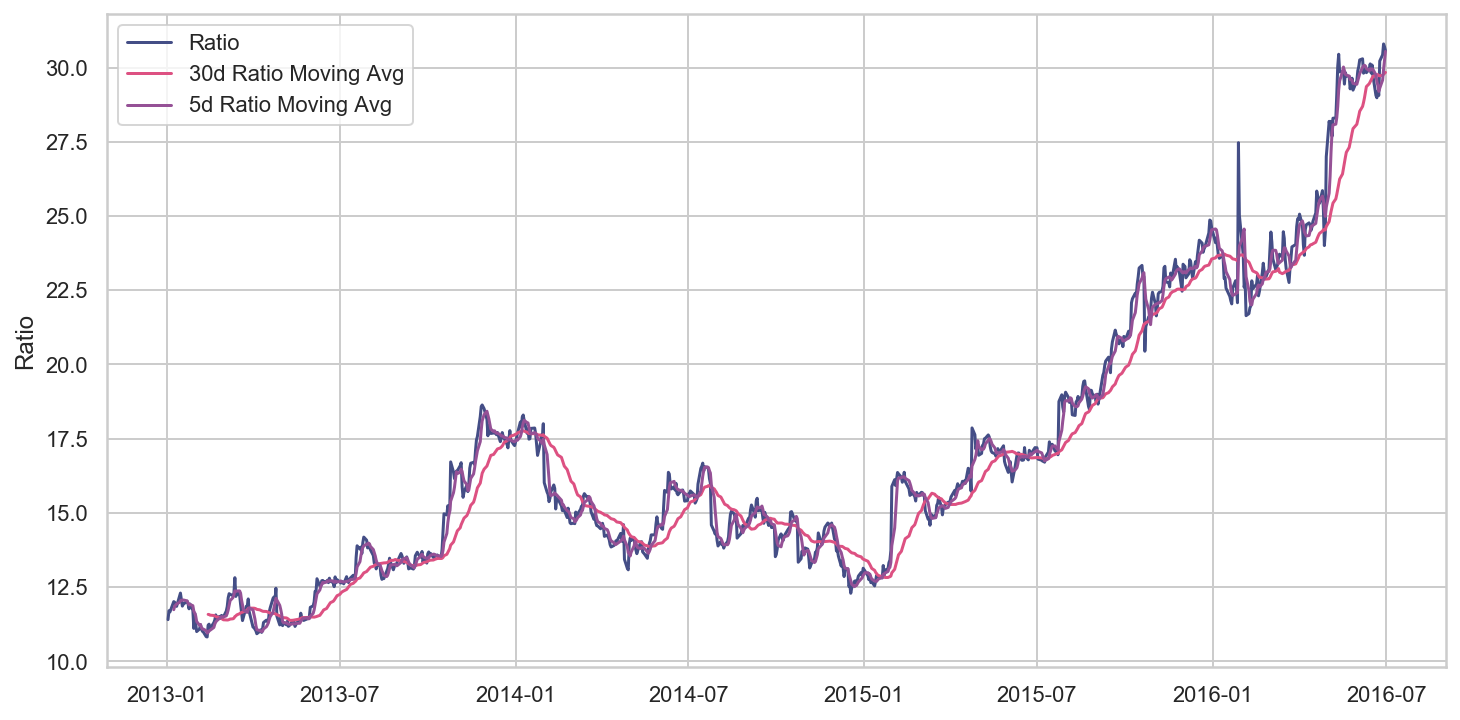

In [154]:
ratio_mav5 = train.rolling(window = 5, center=False).mean()
ratio_mav30 = train.rolling(window = 30, center=False).mean()
std_30 = train.rolling(window = 30, center=False).std()
zscore_30_5 = (ratio_mav5 - ratio_mav30)/std_30
plt.figure(figsize = (12, 6))
plt.plot(train.index, train.values, color = '#444e86')
plt.plot(ratio_mav30.index, ratio_mav30.values, color = '#dd5182')
plt.plot(ratio_mav5.index, ratio_mav5.values, color = '#955196')
plt.legend(['Ratio', '30d Ratio Moving Avg', '5d Ratio Moving Avg'])
plt.ylabel('Ratio')
plt.show()


### PLot the z_score of the moving average and highlight major standard deviations

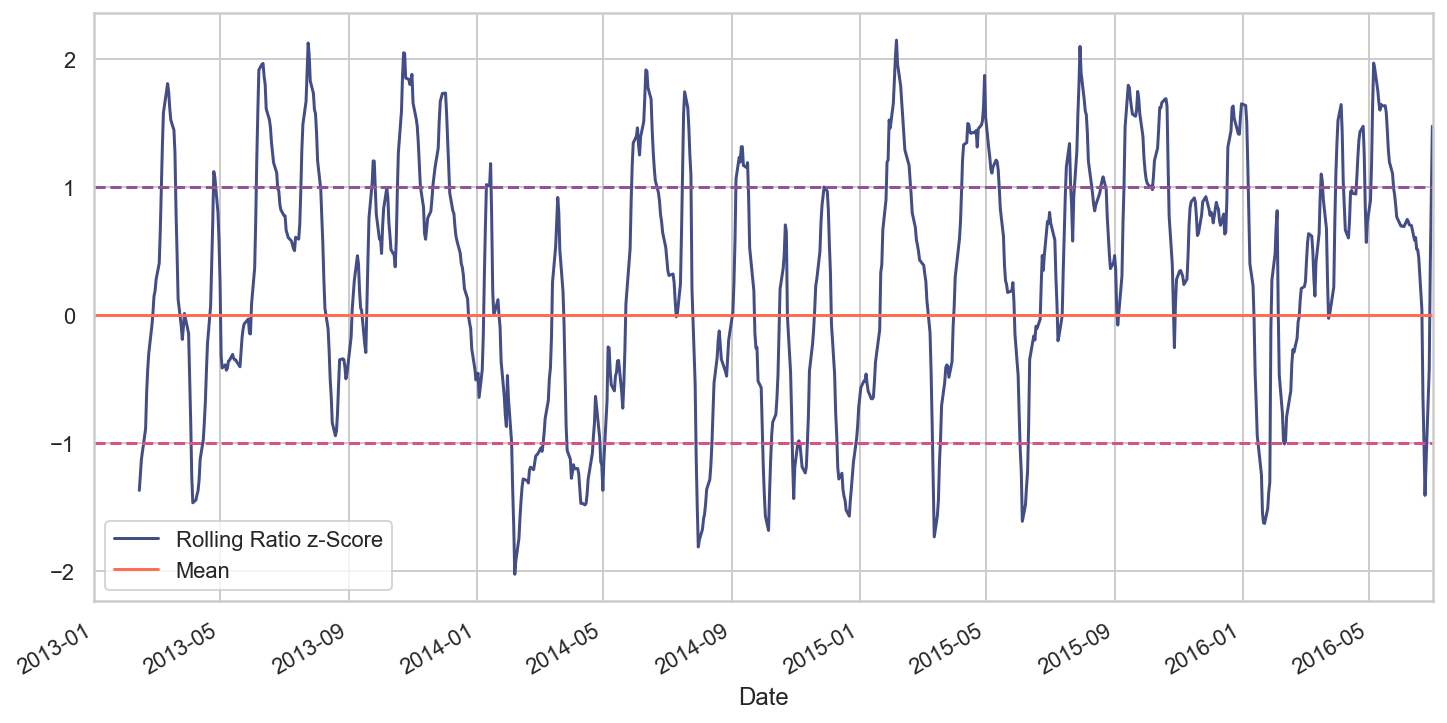

In [156]:
plt.figure(figsize=(12,6))
zscore_30_5.plot(color = '#444e86')
plt.xlim('2013-01-01', '2016-07-01')
plt.axhline(0, color = '#ff6e54')
plt.axhline(1.0, color = '#955196', linestyle = '--')
plt.axhline(-1.0, color = '#dd5182', linestyle = '--')
plt.legend(['Rolling Ratio z-Score', 'Mean'])
plt.show()

### Signal Model
While a standard normal distribution has a mean of 0 and standard deviation 1 with 66% of data falling within %pm;1&sigma;, it appears that for this equity pair, a safer strategy would be to buy and sell at -1.5&sigma; and +1.5&sigma;, respectively. Therefore, we will employ the following signals:
- Buy (1) whenever the z-score is below -1.5, meaning the ratio is expected to increase
- Sell (-1) whenever the z-score is above 1.5, meaning we expect the ratio to decrease

### Training Optimization

Here we test the model on historical data

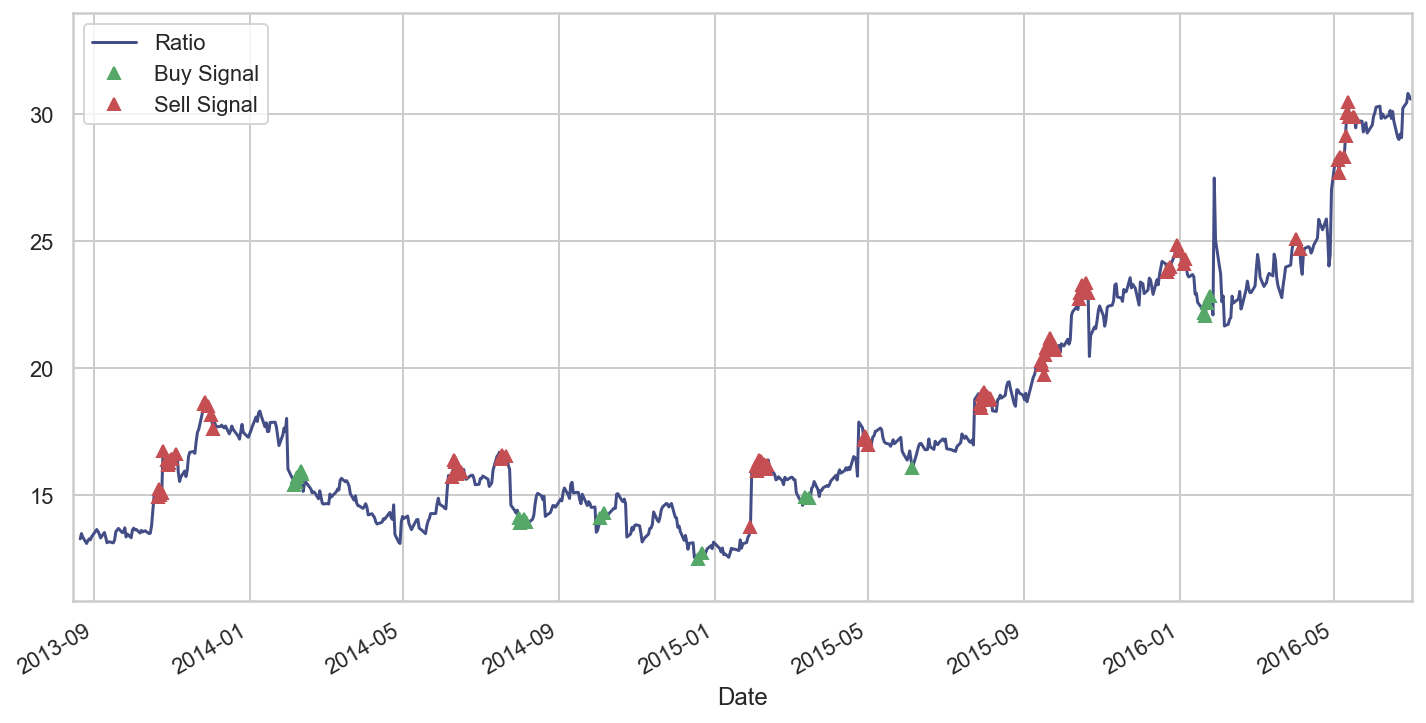

In [162]:
plt.figure(figsize=(12,6))
train[160:].plot(color = '#444e86')
buy = train.copy()
sell = train.copy()
buy[zscore_30_5 > -1.5] = 0
sell[zscore_30_5 < 1.5] = 0
buy[160:].plot(color = 'g', linestyle='None', marker = '^')
sell[160:].plot(color = 'r', linestyle = 'None', marker = '^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15', '2016-07-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

### Plotting the buy and sell signals on their respective stocks; a simple strategy shown here is when the ratio is bought, buy equity S1 and concurrently sell S2 and vice versas when selling the ratio

<Figure size 864x432 with 0 Axes>

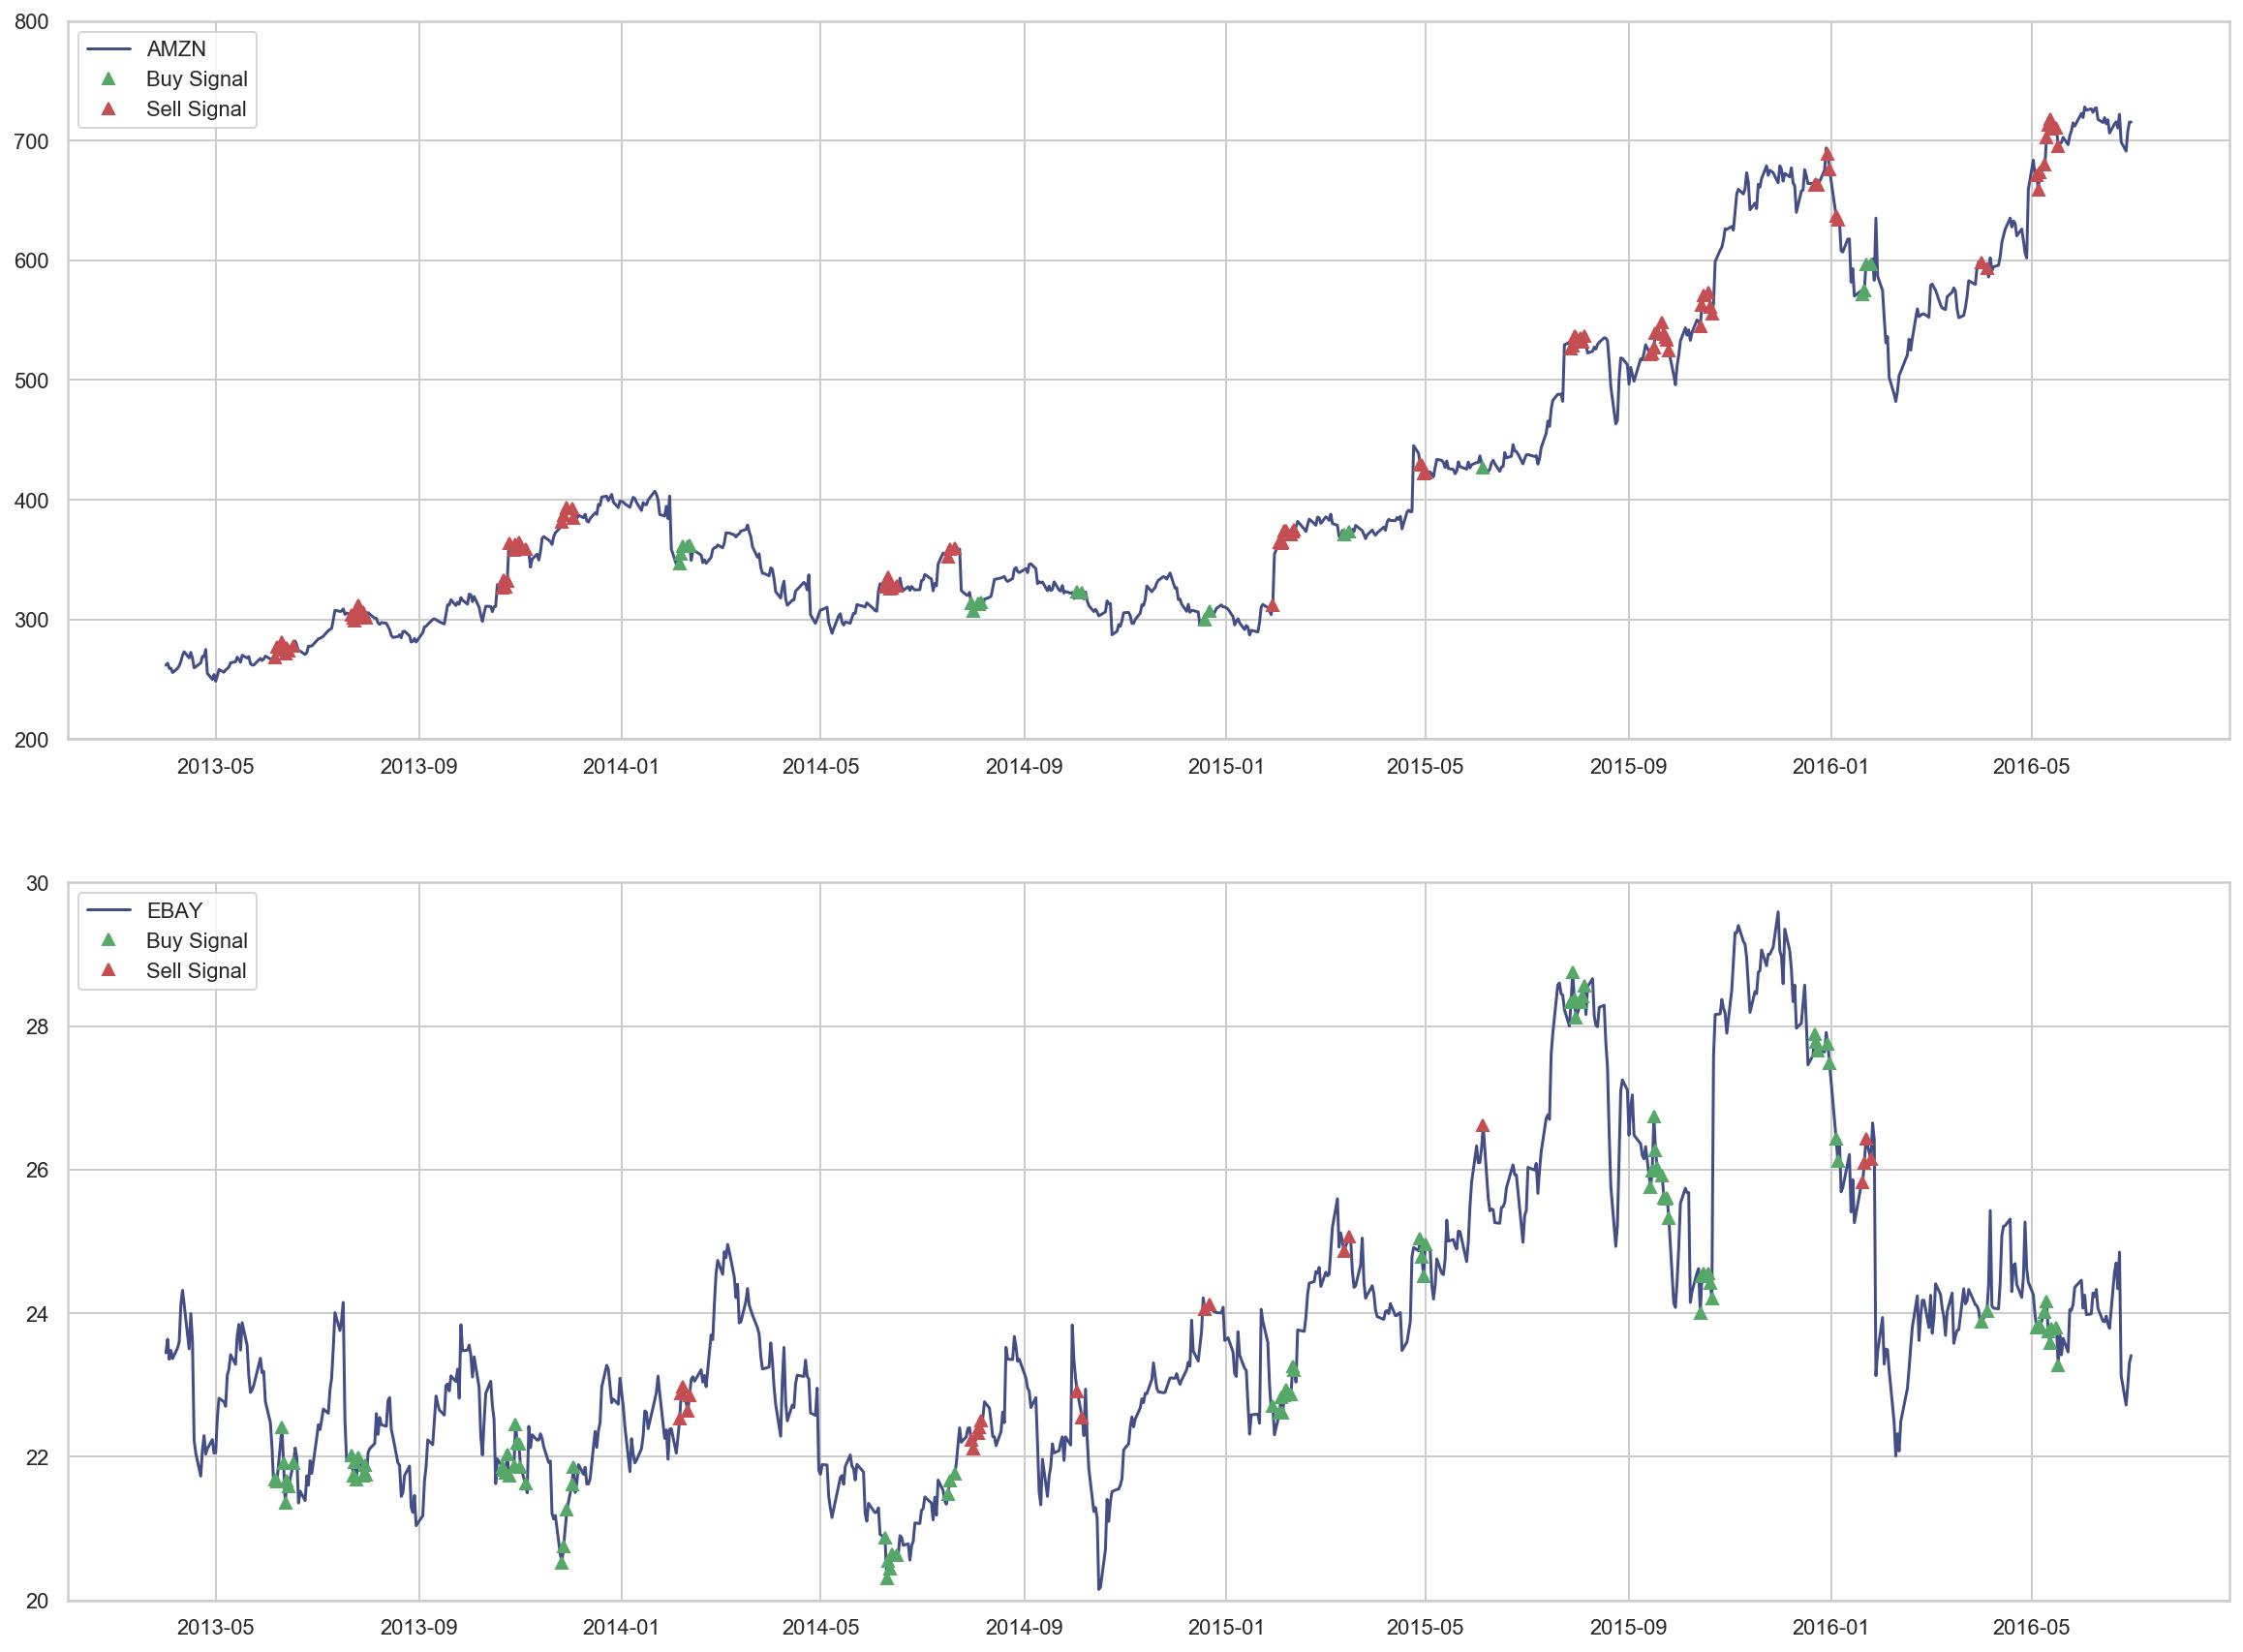

In [181]:
plt.figure(figsize = (12,6))
S1 = df['AMZN'].iloc[:881]
S2 = df['EBAY'].iloc[:881]


buyR = 0*S1.copy()
sellR = 0*S2.copy()

#When you buy the ratio, you buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20,15))
ax1.plot(S1[60:], color = '#444e86')
ax1.plot(buyR[60:], color='g', linestyle='None', marker='^')
ax1.plot(sellR[60:], color='r', linestyle='None', marker='^')
ax1.set_ylim(200, 800)
ax1.legend(['AMZN', 'Buy Signal', 'Sell Signal'])
ax2.plot(S2[60:], color = '#444e86')
ax2.plot(buyR[60:], color='g', linestyle='None', marker='^')
ax2.plot(sellR[60:], color='r', linestyle='None', marker='^')
ax2.set_ylim(20, 30)
ax2.legend(['EBAY', 'Buy Signal', 'Sell Signal'])

plt.show()

### Demonstrate theoretical returns over a selected historical period by employing this strategy

In [236]:
def trade(S1, S2, avg1, avg2):
    if(avg1 == 0) or (avg2 == 0):
        return 0
    ratios = S1/S2
    ma1 = ratios.rolling(window = avg1, center=False).mean()
    ma2 = ratios.rolling(window = avg2, center=False).mean()
    std = ratios.rolling(window = avg2, center=False).std()
    zscore = (ma1-ma2)/std

    #Sim trade
    money = 100000
    S1q = 0
    S2q = 0
    for i in range(len(ratios)):
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            S1q -= 1
            S2q += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], S1q, S2q))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            S1q += 1
            S2q -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money, ratios[i], S1q, S2q))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * S1q + S2[i] * S2q
            S1q = 0
            S2q = 0
            print('Exit pos %s %s %s %s'%(money, ratios[i], S1q, S2q))
    return money


In [237]:
trade(df['AMZN'].iloc[881:], df['EBAY'].iloc[881:], 20, 9)

Buying Ratio 100000.0 24.352053956175297 1 -24.352053956175297
Buying Ratio 100000.0 24.5676796875 2 -48.9197336436753
Buying Ratio 100000.0 24.702175851715698 3 -73.621909495391
Buying Ratio 100000.0 24.38255237628518 4 -98.00446187167617
Buying Ratio 100000.0 24.493561899942797 5 -122.49802377161896
Buying Ratio 100000.0 24.40203871814503 6 -146.900062489764
Buying Ratio 100000.0 24.608667959744963 7 -171.50873044950896
Buying Ratio 100000.0 24.69656002844776 8 -196.2052904779567
Buying Ratio 100000.0 24.6966573532241 9 -220.90194783118082
Buying Ratio 100000.0 24.719229851766002 10 -245.62117768294684
Buying Ratio 100000.0 25.010036025364464 11 -270.6312137083113
Exit pos 100050.2909134103 24.750080808927155 0 0
Exit pos 100050.2909134103 24.78235419779719 0 0
Selling Ratio 100050.2909134103 24.979744842743752 -1 24.979744842743752
Selling Ratio 100050.2909134103 25.047837827872414 -2 50.02758267061617
Selling Ratio 100050.2909134103 24.724453748226612 -3 74.75203641884278
Selling R

100211.28720366326